In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

import pickle


## Random forest

In [2]:
## Read data prepared for modelling
df = pd.read_csv('../data/final_data_for_modelling.csv')

## Remove not required columns
df.drop(columns=["age_group", "neighbourhood", "patientid", "appointmentid",
                    "scheduledday", "appointmentday", "showed"] , inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110519 entries, 0 to 110518
Data columns (total 22 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   gender                                      110519 non-null  object 
 1   age                                         110519 non-null  int64  
 2   scholarship                                 110519 non-null  int64  
 3   hypertension                                110519 non-null  int64  
 4   diabetes                                    110519 non-null  int64  
 5   alcoholism                                  110519 non-null  int64  
 6   handicap                                    110519 non-null  int64  
 7   sms_received                                110519 non-null  int64  
 8   days_between_appointment_and_scheduled_day  110519 non-null  int64  
 9   appointment_day_of_week                     110519 non-null  object 
 

In [3]:
## Check class imbalance
print(df[["no_show"]].value_counts())

no_show
0          88207
1          22312
dtype: int64


In [4]:
# Splitting dataset into test and train
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=["no_show"]), df["no_show"], random_state=0,test_size=0.2)

X_train.head()

,gender,age,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,days_between_appointment_and_scheduled_day,appointment_day_of_week,...,temp,feelslikemax,feelslike,humidity,windspeed,solarradiation,solarenergy,uvindex,rating,previous_app
82584,M,6,0,0,0,0,0,1,7,Wednesday,...,77.8,90.1,79.4,87.9,11.2,177.3,15.2,7.0,5.0,0
74745,F,62,0,1,1,0,0,0,0,Wednesday,...,68.4,74.0,68.4,94.2,3.1,87.7,7.7,3.0,3.0,4
2206,F,66,0,0,0,0,0,1,59,Friday,...,73.3,75.2,73.3,76.6,16.1,77.4,6.6,3.0,3.7,0
38500,F,43,1,0,0,0,0,0,0,Monday,...,72.5,84.8,72.8,78.8,17.5,183.4,15.7,7.0,5.0,1
109629,M,32,0,0,0,0,0,0,0,Wednesday,...,76.0,94.1,77.1,79.9,12.8,140.0,12.1,5.0,3.2,5


In [5]:
## Ordinal encoder for features
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

## Fit encoder on train and apply to test data as well
X_train[["gender"]] = enc.fit_transform(X_train[["gender"]])
X_test[["gender"]] = enc.transform(X_test[["gender"]])

In [6]:
def onehot_encode(X, cols):
    # Treat new categories as a new 'unknown' category (all onehot columns are 0)
    onehot_enc = OneHotEncoder(handle_unknown='ignore')
    # Fit encoder on training data
    onehot_enc.fit(X[cols])
    # Get the names of the new columns created
    colnames = list(onehot_enc.get_feature_names(input_features=cols))
    # Transform the data
    onehot_vals = onehot_enc.transform(X[cols]).toarray()
    # Put transformed data into dataframe
    enc_df = pd.DataFrame(onehot_vals,columns=colnames,index=X.index)
    # Add onehot columns back onto original dataframe and drop the original columns
    X = pd.concat([X,enc_df],axis=1).drop(cols,axis=1)
    return X,onehot_enc

## One hot encode the train data
cols = ["appointment_day_of_week"]
X_train, onehot_enc = onehot_encode(X_train, cols)

X_train.head()


/Users/architkaila/opt/anaconda3/envs/aipi520/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,gender,age,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,days_between_appointment_and_scheduled_day,tempmax,...,solarenergy,uvindex,rating,previous_app,appointment_day_of_week_Friday,appointment_day_of_week_Monday,appointment_day_of_week_Saturday,appointment_day_of_week_Thursday,appointment_day_of_week_Tuesday,appointment_day_of_week_Wednesday
82584,1.0,6,0,0,0,0,0,1,7,84.3,...,15.2,7.0,5.0,0,0.0,0.0,0.0,0.0,0.0,1.0
74745,0.0,62,0,1,1,0,0,0,0,74.0,...,7.7,3.0,3.0,4,0.0,0.0,0.0,0.0,0.0,1.0
2206,0.0,66,0,0,0,0,0,1,59,75.2,...,6.6,3.0,3.7,0,1.0,0.0,0.0,0.0,0.0,0.0
38500,0.0,43,1,0,0,0,0,0,0,82.4,...,15.7,7.0,5.0,1,0.0,1.0,0.0,0.0,0.0,0.0
109629,1.0,32,0,0,0,0,0,0,0,89.6,...,12.1,5.0,3.2,5,0.0,0.0,0.0,0.0,0.0,1.0


In [7]:
# Apply onehot encoder to test data
colnames = columns=list(onehot_enc.get_feature_names(input_features=cols))
onehot_vals = onehot_enc.transform(X_test[cols]).toarray()

# Put transformed data into dataframe
enc_df = pd.DataFrame(onehot_vals,columns=colnames,index=X_test.index)
# Add onehot columns back onto original dataframe and drop the original columns
X_test = pd.concat([X_test,enc_df],axis=1).drop(cols, axis=1)

X_test.head()

/Users/architkaila/opt/anaconda3/envs/aipi520/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,gender,age,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,days_between_appointment_and_scheduled_day,tempmax,...,solarenergy,uvindex,rating,previous_app,appointment_day_of_week_Friday,appointment_day_of_week_Monday,appointment_day_of_week_Saturday,appointment_day_of_week_Thursday,appointment_day_of_week_Tuesday,appointment_day_of_week_Wednesday
30617,0.0,18,0,0,0,0,0,1,8,64.8,...,14.6,5.0,4.0,0,0.0,0.0,0.0,0.0,1.0,0.0
72651,0.0,18,0,0,0,0,0,0,7,82.5,...,11.6,6.0,3.9,0,0.0,0.0,0.0,1.0,0.0,0.0
43382,0.0,1,0,0,0,0,0,0,0,91.4,...,18.9,8.0,3.7,1,0.0,0.0,0.0,0.0,1.0,0.0
28742,0.0,8,0,0,0,0,0,0,2,78.8,...,7.1,3.0,3.4,0,0.0,0.0,0.0,1.0,0.0,0.0
47295,0.0,40,1,1,0,0,0,1,42,78.2,...,16.0,7.0,2.6,0,0.0,1.0,0.0,0.0,0.0,0.0


In [8]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth' : [3,4,5,6],
    'min_samples_leaf': [2, 3, 4, 5],
    'n_estimators': [25, 50, 75],
    'random_state':[0],
    'criterion' :['gini', 'entropy'],
    'class_weight': [{1:4}]
}

# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                            cv = 3, n_jobs = -1, verbose = 2, scoring='precision')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 96 candidates, totalling 288 fits
[CV] END class_weight={1: 4}, criterion=gini, max_depth=3, min_samples_leaf=2, n_estimators=25, random_state=0; total time=   0.5s
[CV] END class_weight={1: 4}, criterion=gini, max_depth=3, min_samples_leaf=2, n_estimators=25, random_state=0; total time=   0.5s
[CV] END class_weight={1: 4}, criterion=gini, max_depth=3, min_samples_leaf=2, n_estimators=25, random_state=0; total time=   0.5s
[CV] END class_weight={1: 4}, criterion=gini, max_depth=3, min_samples_leaf=2, n_estimators=50, random_state=0; total time=   0.9s
[CV] END class_weight={1: 4}, criterion=gini, max_depth=3, min_samples_leaf=2, n_estimators=50, random_state=0; total time=   1.0s
[CV] END class_weight={1: 4}, criterion=gini, max_depth=3, min_samples_leaf=2, n_estimators=50, random_state=0; total time=   1.0s
[CV] END class_weight={1: 4}, criterion=gini, max_depth=3, min_samples_leaf=3, n_estimators=25, random_state=0; total time=   0.5s
[CV] END class_weight

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'class_weight': [{1: 4}],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 4, 5, 6],
                         'min_samples_leaf': [2, 3, 4, 5],
                         'n_estimators': [25, 50, 75], 'random_state': [0]},
             scoring='precision', verbose=2)

In [9]:
## params for best model
grid_search.best_params_

{'class_weight': {1: 4},
 'criterion': 'gini',
 'max_depth': 6,
 'min_samples_leaf': 2,
 'n_estimators': 25,
 'random_state': 0}

In [10]:
## Train the best model
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

y_pred_train = best_model.predict(X_train)

print("Train Report")

print(classification_report(y_train, y_pred_train))

Train Report
              precision    recall  f1-score   support

           0       0.94      0.46      0.62     70549
           1       0.30      0.88      0.44     17866

    accuracy                           0.55     88415
   macro avg       0.62      0.67      0.53     88415
weighted avg       0.81      0.55      0.59     88415



In [11]:
## AUROC Score
roc_auc_score(y_train, y_pred_train)

0.6747324529176719

In [12]:
## test the model
y_pred_test = best_model.predict(X_test)

print("Test Report")
print(classification_report(y_test, y_pred_test))

Test Report
              precision    recall  f1-score   support

           0       0.94      0.46      0.62     17658
           1       0.29      0.88      0.44      4446

    accuracy                           0.54     22104
   macro avg       0.61      0.67      0.53     22104
weighted avg       0.81      0.54      0.58     22104



In [13]:
## Function to plot the PR Curve
def plot_pr_curve(y_test, y_test_prob):

    #calculate precision and recall
    precision, recall, thresholds = precision_recall_curve(y_test, y_test_prob)

    #create precision recall curve
    fig, ax = plt.subplots()
    ax.plot(thresholds, precision[:-1], color='purple')
    ax.plot(thresholds, recall[:-1], color='green')

    #add axis labels to plot
    ax.set_title('Precision-Recall Curve')
    ax.set_ylabel('Precision/Recall')
    ax.set_xlabel('Threshold')

    #display plot
    plt.show()

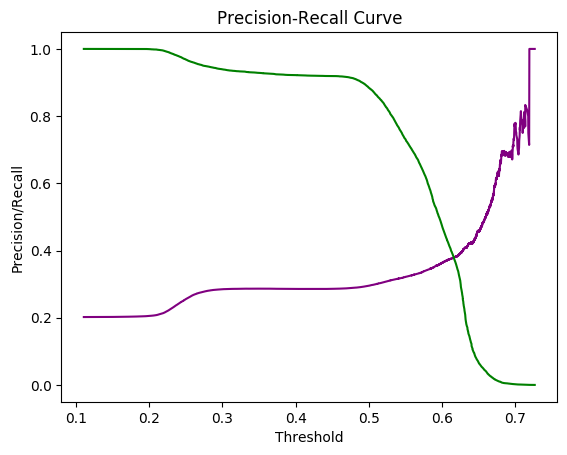

In [14]:
## Plot PR for train data
y_pred_probs = best_model.predict_proba(X_train)
y_pred_probs = y_pred_probs[:, 1]

plot_pr_curve(y_train, y_pred_probs)

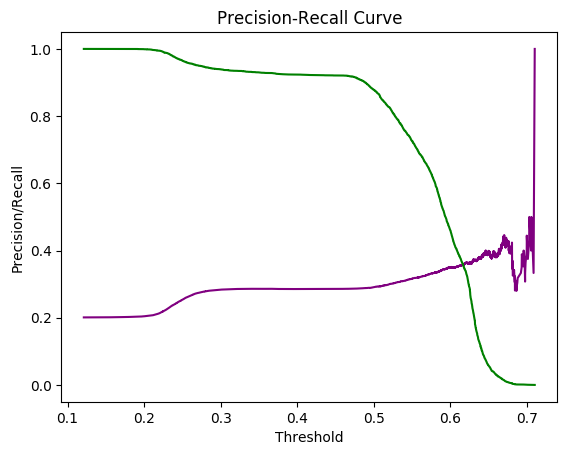

In [15]:
## Plot PR for test data
y_pred_probs = best_model.predict_proba(X_test)
y_pred_probs = y_pred_probs[:, 1]

plot_pr_curve(y_test, y_pred_probs)

In [16]:
## Feature importances
importances = best_model.feature_importances_
forest_importances = pd.Series(importances, index=X_train.columns)
forest_importances.sort_values(ascending=False)

days_between_appointment_and_scheduled_day    0.738483
sms_received                                  0.072887
age                                           0.057504
previous_app                                  0.023266
hypertension                                  0.014535
humidity                                      0.010870
scholarship                                   0.009690
temp                                          0.009569
windspeed                                     0.009015
feelslike                                     0.008298
rating                                        0.007801
feelslikemax                                  0.006318
solarradiation                                0.005785
tempmax                                       0.005475
solarenergy                                   0.004744
alcoholism                                    0.003053
gender                                        0.002663
appointment_day_of_week_Thursday              0.002489
appointmen

## Save the best fit model

In [17]:
# save the model to disk
filename = './finalized_model.sav'
pickle.dump(best_model, open(filename, 'wb'))

## XgBoost

In [18]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV

param = {"subsample":[0.7, 0.8, 0.9],
"colsample_bytree":[0.7, 0.8, 0.9],
"max_depth":[2, 3, 4],
"min_child_weight":[2, 3, 4],
"learning_rate":[0.01, 0.1, 0.05],
"n_estimators":[30, 40, 50]}


model = XGBClassifier(n_estimators=100, n_jobs=-1)
model_gs = GridSearchCV(model,param_grid=param,cv=3,scoring="f1", n_jobs=-1, verbose = 2)

model_gs.fit(X_train, y_train)
#model.fit(X_train,y_train, early_stopping_rounds=10)

model = model_gs.best_estimator_
print(model_gs.best_params_)

Fitting 3 folds for each of 729 candidates, totalling 2187 fits
[CV] END class_weight={1: 4}, criterion=gini, max_depth=3, min_samples_leaf=2, n_estimators=25, random_state=0; total time=   0.4s
[CV] END class_weight={1: 4}, criterion=gini, max_depth=3, min_samples_leaf=3, n_estimators=25, random_state=0; total time=   0.4s
[CV] END class_weight={1: 4}, criterion=gini, max_depth=3, min_samples_leaf=3, n_estimators=75, random_state=0; total time=   1.2s
[CV] END class_weight={1: 4}, criterion=gini, max_depth=3, min_samples_leaf=5, n_estimators=25, random_state=0; total time=   0.4s
[CV] END class_weight={1: 4}, criterion=gini, max_depth=3, min_samples_leaf=5, n_estimators=75, random_state=0; total time=   1.2s
[CV] END class_weight={1: 4}, criterion=gini, max_depth=4, min_samples_leaf=3, n_estimators=25, random_state=0; total time=   0.5s
[CV] END class_weight={1: 4}, criterion=gini, max_depth=4, min_samples_leaf=3, n_estimators=75, random_state=0; total time=   1.6s
[CV] END class_weig

/opt/homebrew/Caskroom/miniconda/base/envs/aipi510project/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END class_weight={1: 4}, criterion=gini, max_depth=3, min_samples_leaf=3, n_estimators=25, random_state=0; total time=   0.4s
[CV] END class_weight={1: 4}, criterion=gini, max_depth=3, min_samples_leaf=3, n_estimators=50, random_state=0; total time=   1.1s
[CV] END class_weight={1: 4}, criterion=gini, max_depth=3, min_samples_leaf=4, n_estimators=75, random_state=0; total time=   1.6s
[CV] END class_weight={1: 4}, criterion=gini, max_depth=4, min_samples_leaf=2, n_estimators=75, random_state=0; total time=   1.9s
[CV] END class_weight={1: 4}, criterion=gini, max_depth=4, min_samples_leaf=4, n_estimators=50, random_state=0; total time=   1.3s
[CV] END class_weight={1: 4}, criterion=gini, max_depth=5, min_samples_leaf=2, n_estimators=25, random_state=0; total time=   0.7s
[CV] END class_weight={1: 4}, criterion=gini, max_depth=5, min_samples_leaf=2, n_estimators=75, random_state=0; total time=   2.5s
[CV] END class_weight={1: 4}, criterion=gini, max_depth=5, min_samples_leaf=4, n_es

In [19]:
## Train the best model
model = XGBClassifier(colsample_bytree= 0.8, learning_rate=0.2, max_depth=6,
                    min_child_weight=2, n_estimators=50, subsample=0.8, n_jobs=-1)


model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)

print("Train Report")
print(classification_report(y_train, y_pred_train))



Train Report
              precision    recall  f1-score   support

           0       0.81      1.00      0.89     70549
           1       0.78      0.05      0.10     17866

    accuracy                           0.81     88415
   macro avg       0.79      0.52      0.50     88415
weighted avg       0.80      0.81      0.73     88415



In [20]:
## test the model
y_pred_test = model.predict(X_test)

print("Test Report")
print(classification_report(y_test, y_pred_test))

Test Report
              precision    recall  f1-score   support

           0       0.80      0.99      0.89     17658
           1       0.57      0.03      0.06      4446

    accuracy                           0.80     22104
   macro avg       0.69      0.51      0.48     22104
weighted avg       0.76      0.80      0.72     22104



## PCA

In [21]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from os.path import exists

path = Path('')

import warnings
warnings.filterwarnings("ignore")

In [22]:
# Standardize each feature

# Calculate mean and stdev
mu = X_train.mean(axis=0)
stdev = X_train.std(axis=0)

# Calculate the standardized data
X_train_std = (X_train-mu) / stdev

X_train_std.head()

,gender,age,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,days_between_appointment_and_scheduled_day,tempmax,...,solarenergy,uvindex,rating,previous_app,appointment_day_of_week_Friday,appointment_day_of_week_Monday,appointment_day_of_week_Saturday,appointment_day_of_week_Thursday,appointment_day_of_week_Tuesday,appointment_day_of_week_Wednesday
82584,1.362737,-1.345937,-0.330970,-0.495858,-0.277789,-0.17765,-0.137626,1.452209,-0.208357,0.514855,...,-0.114010,0.176619,1.480345,-0.323812,-0.456180,-0.509259,-0.019614,-0.428669,-0.550119,1.809964
74745,-0.733809,1.078295,-0.330970,2.016682,3.599812,-0.17765,-0.137626,-0.688598,-0.667434,-0.638942,...,-1.683247,-2.268983,-1.662847,0.691990,-0.456180,-0.509259,-0.019614,-0.428669,-0.550119,1.809964
2206,-0.733809,1.251454,-0.330970,-0.495858,-0.277789,-0.17765,-0.137626,1.452209,3.201934,-0.504519,...,-1.913402,-2.268983,-0.562730,-0.323812,2.192091,-0.509259,-0.019614,-0.428669,-0.550119,-0.552491
38500,-0.733809,0.255787,3.021387,-0.495858,-0.277789,-0.17765,-0.137626,-0.688598,-0.667434,0.302019,...,-0.009394,0.176619,1.480345,-0.069862,-0.456180,1.963616,-0.019614,-0.428669,-0.550119,-0.552491
109629,1.362737,-0.220401,-0.330970,-0.495858,-0.277789,-0.17765,-0.137626,-0.688598,-0.667434,1.108557,...,-0.762628,-1.046182,-1.348528,0.945940,-0.456180,-0.509259,-0.019614,-0.428669,-0.550119,1.809964


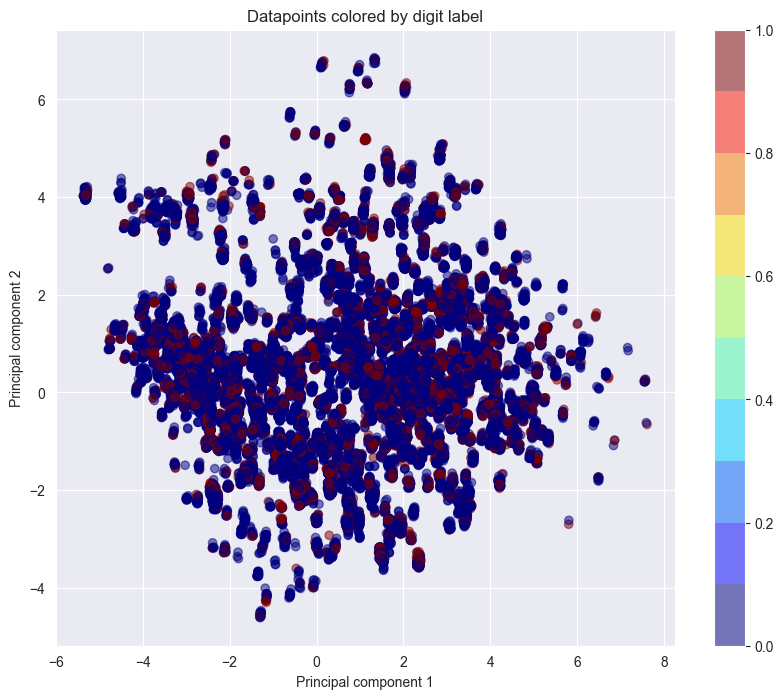

In [23]:
# PCA on the standardized data using 2 principal components for viewing
pca = PCA(2)
pca.fit(X_train_std)

# Project the data onto the new principal components axes
projected = pca.transform(X_train_std)

# Plot the transformed data on the two principal dimensions
fig = plt.figure(figsize=(10,8))
plt.scatter(projected[:, 0], projected[:, 1],
            c=y_train, alpha=0.5,
            cmap=plt.cm.get_cmap('jet', 10))
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.title('Datapoints colored by digit label')
plt.colorbar()
plt.show()